# Lab 2: Hotel reviews

Generate word clouds for good and bad hotel reviews

Objectives:
- part of speech tagging with spacy
- extract phrases that match a part of speech pattern
- scale processing pipeline with nlp.pipe
- compute c-values

In [119]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm import tqdm
from wordcloud import WordCloud

In [120]:
df = pd.read_pickle("/data/hotels.pkl.gz")

In [121]:
df = df.sample(frac=.1)

In [133]:
df.head()

,title,text,overall,value,service,cleanliness
26275,“Had a wonderful stay”,“Had a wonderful stay” Stayed from June 19-21....,5.0,4.0,4.0,4.0
36348,“Best place to stay in the nation's capital !!”,“Best place to stay in the nation's capital !!...,5.0,NaN,NaN,NaN
258930,“A great find in lower Manhattan”,“A great find in lower Manhattan” This is a ti...,5.0,5.0,5.0,5.0
224857,"“Nice hotel, great location... Front desk impr...","“Nice hotel, great location... Front desk impr...",3.0,3.0,3.0,3.0
113562,“Excellent hotel in fantastic location with to...,“Excellent hotel in fantastic location with to...,5.0,4.0,5.0,5.0


In [123]:
df['text'] = df['title'] + " " + df['text']

---

## Collect candidate term phrases

Collect all sequences of words that match the part-of-speech pattern `(Adj|Noun)+ Noun`

In [134]:
import spacy
from spacy.matcher import Matcher

In [135]:
nlp = spacy.load(
    "en_core_web_sm", exclude=["parser", "ner", "lemmatizer", "attribute_ruler"]
)

In [136]:
matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP", "HYPH"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNS", "NNP"]}},
        ]
    ],
)

In [137]:
def get_phrases(doc):
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]

In [138]:
doc = nlp(df['text'].iloc[0])

In [139]:
print([(t,t.tag_) for t in doc])

[(“, '``'), (Had, 'VBD'), (a, 'DT'), (wonderful, 'JJ'), (stay, 'NN'), (”, "''"), (Stayed, 'VBD'), (from, 'IN'), (June, 'NNP'), (19, 'CD'), (-, 'SYM'), (21, 'CD'), (., '.'), (I, 'PRP'), (made, 'VBD'), (the, 'DT'), (reservations, 'NNS'), (with, 'IN'), (a, 'DT'), (little, 'JJ'), (trepidation, 'NN'), (as, 'IN'), (Tripadvisor, 'NN'), (reviewers, 'NNS'), (seemed, 'VBD'), (to, 'IN'), (either, 'CC'), (rant, 'JJ'), (about, 'IN'), (the, 'DT'), (hotel, 'NN'), (or, 'CC'), (rave, 'VB'), (about, 'IN'), (it, 'PRP'), (., '.'), ( , '_SP'), (We, 'PRP'), (had, 'VBD'), (a, 'DT'), (very, 'RB'), (pleasurable, 'JJ'), (stay, 'NN'), (., '.'), (We, 'PRP'), (had, 'VBD'), (a, 'DT'), (3rd, 'JJ'), (floor, 'NN'), (,, ','), (ocean, 'NN'), (front, 'JJ'), (room, 'NN'), (with, 'IN'), (king, 'NN'), (bed, 'NNP'), (&, 'CC'), (pull, 'VB'), (-, 'HYPH'), (out, 'RP'), (sofa, 'NN'), (,, ','), (refrigerator, 'NN'), (,, ','), (and, 'CC'), (microwave, 'NN'), (., '.'), (We, 'PRP'), (arrived, 'VBD'), (early, 'RB'), (on, 'IN'), (the,

In [140]:
print(list(get_phrases(doc)))

[('wonderful', 'stay'), ('little', 'trepidation'), ('tripadvisor', 'reviewers'), ('pleasurable', 'stay'), ('3rd', 'floor'), ('front', 'room'), ('ocean', 'front', 'room'), ('king', 'bed'), ('beach', 'time'), ('basic', 'hotel'), ('hotel', 'room'), ('basic', 'hotel', 'room'), ('good', 'condition'), ('milk', 'profits'), ('morning', 'coffee'), ('evening', 'wine'), ('continental', 'breakfast'), ('waffle', 'machine'), ('cul', '-', 'de'), ('de', '-'), ('cul', '-', 'de', '-'), ('-', 'sac'), ('de', '-', 'sac'), ('cul', '-', 'de', '-', 'sac'), ('sac', 'street'), ('-', 'sac', 'street'), ('de', '-', 'sac', 'street'), ('cul', '-', 'de', '-', 'sac', 'street'), ('small', 'shop'), ('pacific', 'beach'), ('beach', 'surf'), ('pacific', 'beach', 'surf'), ('surf', 'shop'), ('beach', 'surf', 'shop'), ('pacific', 'beach', 'surf', 'shop'), ('same', 'complex'), ('grand', 'ave'), ('ave', 'shop'), ('grand', 'ave', 'shop'), ('surf', 'lessons'), ('green', 'flash'), ('strong', 'drinks'), ('small', 'condos'), ('frien

In [131]:
candidates = list(
    concat(map(get_phrases, nlp.pipe(tqdm(df["text"]), batch_size=20, n_process=4)))
)

100%|██████████| 23129/23129 [00:59<00:00, 387.50it/s]


In [141]:
import pickle

with open("cands.pkl", "wb") as out:
    pickle.dump(candidates, out)

In [142]:
candidates[:10]

[('wonderful', 'stay'),
 ('little', 'trepidation'),
 ('tripadvisor', 'reviewers'),
 ('pleasurable', 'stay'),
 ('3rd', 'floor'),
 ('front', 'room'),
 ('ocean', 'front', 'room'),
 ('king', 'bed'),
 ('beach', 'time'),
 ('basic', 'hotel')]

In [143]:
freqs = defaultdict(nltk.FreqDist)
for c in candidates:
    freqs[len(c)][c] += 1

In [144]:
freqs.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [145]:
freqs[16]

FreqDist({('washington', 'monument', '-', 'capital', 'building', '-', 'white', 'house', '-', 'jefferson', 'memorial', '-', 'smithsonian', 'buildings', '-', 'museums'): 1})

In [146]:
freqs[9].most_common(10)

[(('james', '-', 'bond', '-', "villian's", '-', 'lair', 'pool', 'area'), 1),
 (('noicy', 'ac', '-', 'expensive', 'wifi', '-', 'slow', 'elevators', 'tips'),
  1),
 (('people', '-', 'great', 'location', '-', 'great', 'food-', 'great', 'view'),
  1),
 (('hilton',
   'garden',
   'inn',
   '-',
   'houston',
   'energy',
   'corridor',
   'last',
   'week'),
  1),
 (('enthusiastic',
   'full',
   '-',
   'service',
   'business',
   '-',
   'savvy',
   'front',
   'desk'),
  1),
 (('quick', 'pros', '-', 'clean', 'rooms', '-', 'great', 'maid', 'service'),
  1),
 (('personale',
   'disponibile',
   '-',
   'bella',
   'grande',
   'e',
   'pulita',
   'la',
   'camera-'),
  1),
 (('disponibile',
   '-',
   'bella',
   'grande',
   'e',
   'pulita',
   'la',
   'camera-',
   'abbondante'),
  1),
 (('la',
   'colazione',
   '-',
   'posizione',
   'eccellente',
   'e',
   'strategica',
   '-',
   'strada'),
  1),
 (('colazione',
   '-',
   'posizione',
   'eccellente',
   'e',
   'strategica',

-----

## Extract terms

Calculate c-values for candidate phrases

$$\textrm{C-value}(a)=
\begin{cases}
\log_2|a|\cdot f(a) & \mbox{if } a \mbox{ is not nested}\\
\log_2|a|\left(f(a)-\frac{1}{P(T_a)}\sum_{b\in T_a}f(b)\right) & \mbox{otherwise}\\
\end{cases}
$$

and select terms above threshold value $\theta$

In [147]:
def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from nltk.ngrams(term, m)


def c_value(F, theta):

    termhood = nltk.FreqDist()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = np.log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

In [148]:
terms = c_value(freqs, theta=100)

In [149]:
terms.most_common(10)

[(('front', 'desk'), 4312.0),
 (('great', 'location'), 3364.0),
 (('new', 'york'), 2034.0),
 (('times', 'square'), 1624.0),
 (('great', 'hotel'), 1409.0),
 (('room', 'service'), 1345.0),
 (('front', 'desk', 'staff'), 1196.6466880444727),
 (('check', '-', 'in'), 1076.189537989665),
 (('good', 'location'), 1020.0),
 (('nice', 'hotel'), 930.0)]

Check threshold: are the items at the bottom of the list (with the lowest c-values) really terms? If not, increase $\theta$ and try again. Repeat until we're happy with the results.

In [150]:
terms.most_common()[-10:]

[(('flat', '-', 'screen'), 103.02256254687515),
 (('bathroom', 'door'), 103.0),
 (('city', 'view'), 103.0),
 (('light', 'sleeper'), 102.0),
 (('many', 'people'), 102.0),
 (('excellent', 'stay'), 102.0),
 (('historic', 'hotel'), 102.0),
 (('la', 'quinta'), 102.0),
 (('golden', 'gate', 'bridge'), 101.43760004615399),
 (('9th', 'floor'), 101.0)]

In [151]:
terms.most_common()[-10:]

[(('flat', '-', 'screen'), 103.02256254687515),
 (('bathroom', 'door'), 103.0),
 (('city', 'view'), 103.0),
 (('light', 'sleeper'), 102.0),
 (('many', 'people'), 102.0),
 (('excellent', 'stay'), 102.0),
 (('historic', 'hotel'), 102.0),
 (('la', 'quinta'), 102.0),
 (('golden', 'gate', 'bridge'), 101.43760004615399),
 (('9th', 'floor'), 101.0)]

In [152]:
terms.most_common(10)

[(('front', 'desk'), 4312.0),
 (('great', 'location'), 3364.0),
 (('new', 'york'), 2034.0),
 (('times', 'square'), 1624.0),
 (('great', 'hotel'), 1409.0),
 (('room', 'service'), 1345.0),
 (('front', 'desk', 'staff'), 1196.6466880444727),
 (('check', '-', 'in'), 1076.189537989665),
 (('good', 'location'), 1020.0),
 (('nice', 'hotel'), 930.0)]

Save terms for later use

In [153]:
with open('terms.txt', 'w') as f:
    for term in terms:
        print(' '.join(term), file=f)

-----

## Multi-word tokenizer

Here we define a tokenizer that recognizes multi-word terms as single tokens

In [154]:
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

In [155]:
nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)
phraser = PhraseMatcher(nlp.vocab, attr="LOWER")

In [156]:
with open('terms.txt', 'r') as f:
    phraser.add("TERM", [nlp.tokenizer(t.strip()) for t in f])

In [157]:
def tokenize(text, sep="_"):
    doc = nlp.tokenizer(text)
    with doc.retokenize() as r:
        for span in filter_spans(phraser(doc, as_spans=True)):
            r.merge(span)
    return [t.norm_.replace(" ", sep) for t in doc if not t.is_space and not t.is_punct]

In [158]:
print(tokenize(df['text'].iloc[0]))

['had', 'a', 'wonderful_stay', 'stayed', 'from', 'june', '19', '21', 'i', 'made', 'the', 'reservations', 'with', 'a', 'little', 'trepidation', 'as', 'tripadvisor', 'reviewers', 'seemed', 'to', 'either', 'rant', 'about', 'the', 'hotel', 'or', 'rave', 'about', 'it', 'we', 'had', 'a', 'very', 'pleasurable', 'stay', 'we', 'had', 'a', '3rd_floor', 'ocean', 'front', 'room', 'with', 'king_bed', 'pull', 'out', 'sofa', 'refrigerator', 'and', 'microwave', 'we', 'arrived', 'early', 'on', 'the', '21st', 'and', 'opi', 'accommodated', 'us', 'by', 'getting', 'us', 'in', 'the', 'room', 'by', '12:00', 'they', 'also', 'allowed', 'us', 'to', 'keep', 'our', 'car', 'parked', 'in', 'the', 'garage', 'until', '3:00', 'on', 'our', 'day', 'of', 'departure', 'so', 'we', 'could', 'enjoy', 'more', 'beach', 'time', 'the', 'room', 'was', 'a', 'basic', 'hotel_room', 'but', 'everything', 'was', 'functional', 'clean', 'and', 'in', 'good', 'condition', 'while', 'we', 'were', 'there', 'they', 'were', 'painting', 'the', '

----

## Word clouds

In this last section, use the tokenizer defined above to make some word clouds comparing good and bad hotels (let's say good = five stars and bad = one or two stars). You might want to look at both the overall rating and some of the sub-scores (like value and service). Can you draw any conclusions that might be useful for hotel owners and managers?

When you are finished, download your notebook file (with a name ending in .ipynb) and submit it via Canvas.

In [160]:
df['text'].apply(tokenize)

26275     [had, a, wonderful_stay, stayed, from, june, 1...
36348     [best, place, to, stay, in, the, nation, 's, c...
258930    [a, great, find, in, lower, manhattan, this, i...
224857    [nice_hotel, great_location, front_desk, impro...
113562    [excellent_hotel, in, fantastic_location, with...
                                ...                        
81368     [surprisingly, appealing, this, property, is, ...
234769    [classy, place, the, westin, sits, directly, a...
197804    [comfortable, stay, great, neighborhood, we, j...
258833    [traditional, and, reliable, this, hotel, when...
106542    [smallest, room, i, have, ever, stayed, in, gr...
Name: text, Length: 23129, dtype: object

In [164]:
len(df), len(df.query('overall == 5')), len(df.query('overall <= 2'))

(23129, 9550, 3108)

In [165]:
from nltk import FreqDist

In [167]:
FreqDist(tokenize(df['text'].loc[0]))

FreqDist({'the': 5, 'was': 4, 'we': 2, 'and': 2, 'to': 2, 'perfect': 1, 'reasonable': 1, 'spent': 1, 'four': 1, 'days': 1, ...})

In [168]:
bad = FreqDist(concat(df.query('overall <= 2')['text'].apply(tokenize)))
total = FreqDist(concat(df['text'].apply(tokenize)))

good = FreqDist(concat(df.query('overall == 5')['text'].apply(tokenize)))

In [171]:
from nltk import BigramAssocMeasures
metrics = BigramAssocMeasures()

In [208]:
metrics.likelihood_ratio(bad['infested'], (total['infested'], bad.N()), total.N())

58.838529735317664

In [210]:
bad_llr = FreqDist()
bad_pmi = FreqDist()

for w in bad:
    if bad[w] > 10:
        bad_llr[w] = metrics.likelihood_ratio(bad[w], (total[w], bad.N()), total.N())
        bad_pmi[w] = metrics.pmi(bad[w], (total[w], bad.N()), total.N())

In [211]:
bad_llr.most_common(10)

[('not', 1679.0826027173534),
 ('great', 1571.4366919611539),
 ('very', 1408.8422504018572),
 ('told', 1400.4841967075272),
 ('i', 1273.5198227864566),
 ('dirty', 1250.2047467210327),
 ('worst', 966.7959984100567),
 ('that', 948.0855957032541),
 ('they', 947.802802980982),
 ('comfortable', 933.4781584035659)]

In [212]:
bad_pmi.most_common(10)

[('infested', 2.496632996836734),
 ('enemy', 2.496632996836734),
 ('scabies', 2.496632996836734),
 ('theft', 2.496632996836734),
 ('disgrace', 2.3811557794167975),
 ('vomit', 2.3711021147528726),
 ('unresponsive', 2.3711021147528726),
 ('discusting', 2.3711021147528726),
 ('burns', 2.3197552347526518),
 ('dishonest', 2.3039879188943395)]

In [213]:
good_llr = FreqDist()
good_pmi = FreqDist()

for w in good:
    if good[w] > 10:
        good_llr[w] = metrics.likelihood_ratio(good[w], (total[w], good.N()), total.N())
        good_pmi[w] = metrics.pmi(good[w], (total[w], good.N()), total.N())

In [214]:
good_llr.most_common(10)

[('not', 2074.1099263739216),
 ('and', 1183.655289279257),
 ('wonderful', 1109.980803370749),
 ('loved', 1001.3912820554616),
 ('great', 940.9634641435578),
 ('but', 936.053718743542),
 ('amazing', 891.383101901059),
 ('staff', 852.3729791237097),
 ('no', 837.6275021001402),
 ('perfect', 826.0518988341066)]

In [215]:
good_pmi.most_common(10)

[('nancy', 1.4680328066465478),
 ('elysee', 1.4680328066465442),
 ('planners', 1.4680328066465442),
 ('granduca', 1.4680328066465442),
 ('drisco', 1.4114492782801804),
 ('talbott', 1.3940322252027677),
 ('galley', 1.3749234022550638),
 ('elysian', 1.3611176027300331),
 ('bravo', 1.3611176027300331),
 ('awe', 1.3525555892266112)]

In [197]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [198]:
def cloud(freqs, k=50):
    plt.figure(figsize=(8,8))
    wc = WordCloud(width=750,
                   height=750,
                   background_color='black').generate_from_frequencies(freqs)
    plt.axis('off')
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

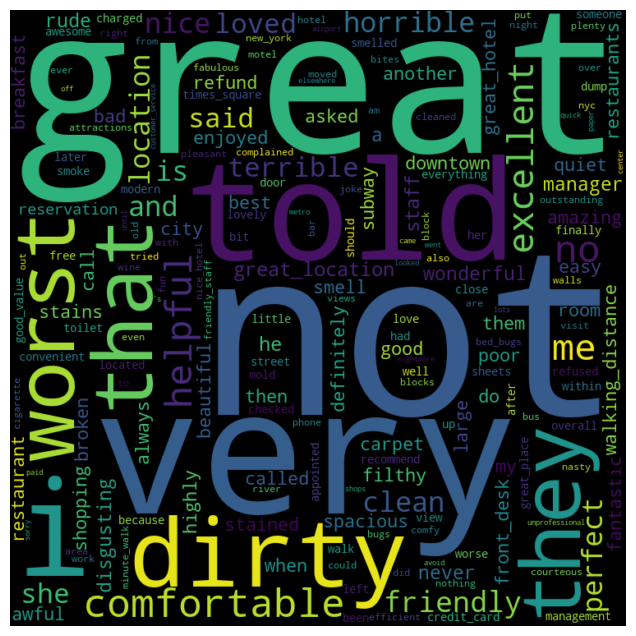

In [202]:
cloud(bad_llr)

The word cloud above for bad hotel reviews contains both positive and negative words. 
The most likely reason is that they used the word "not" in front of a positive word to describe it negatively.

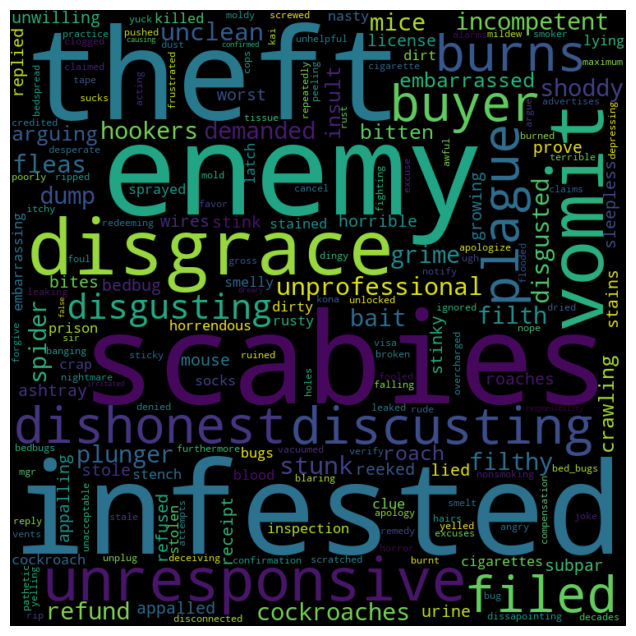

In [205]:
cloud(bad_pmi)

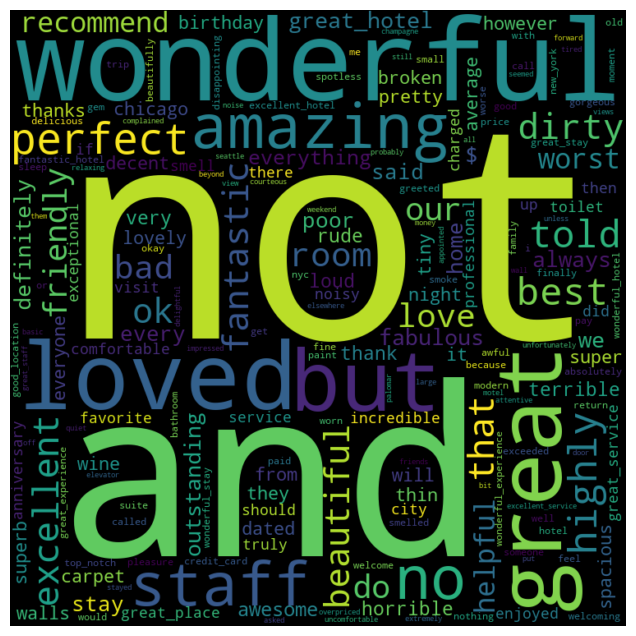

In [216]:
cloud(good_llr)

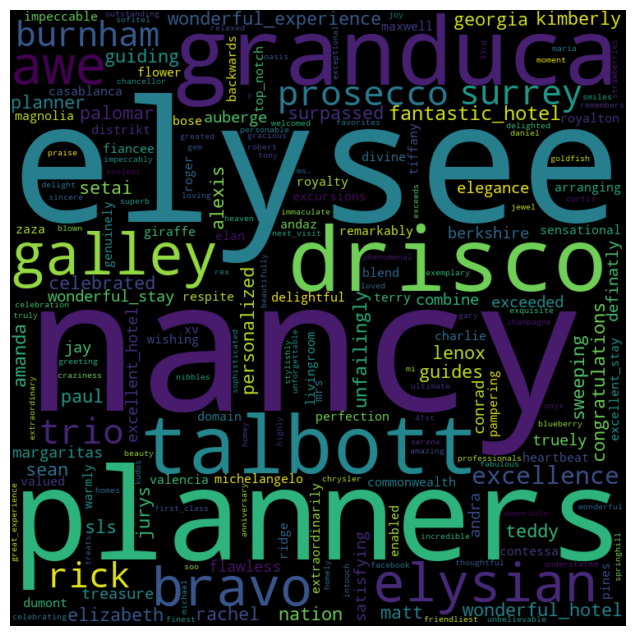

In [217]:
cloud(good_pmi)

Here are some of the most common words used in either good or bad hotel reviews:

Bad hotel reviews (likelihood ratio): 'not', 'great', 'very'

Bad hotel reviews (pointwise mutual independence): 'infested', 'enemy', 'scabies'

Good hotel reviews (likelihood ratio): 'not', 'and', 'wonderful'

Good hotel reviews (pointwise mutual independence): 'nancy', 'elysee', 'planners'

For words used in good hotel reviews found using pointwise mutual independence, it seems that names or proper nouns are the most common. People like to give recognition for good service, which is probably why the most commonly used words in the good reviews are names.  